# Application IA
Etudiants | Date | Sujet
:---|:---|:---
Jonathan Heno | 22/05/2020 | "Hey Snips!": Détection de mot d'éveil

# Introduction
L'Unité Complémentaire d'Enseignement "Application IA", a pour vocation de nous confronter à des problèmes concrets pouvant être résolus par apprentissage supervisé. L'approche est ici avant tout d'ordre pratique et requiert de l'élève de prendre des initiatives (en regard des connaissances qu'il aura pu acquérir dans le domaine jusqu'alors) quant à la solution qu'il souhaite implémenter.

Le présent projet est donc l'occasion pour nous de déployer une architecture capable de détecter un mot d'éveil (ou **wake-up word**), à partir d'un échantillon audio. Ce compte-rendu constitue en somme la synthèse des travaux que j'ai pu effectuer sur le projet, fruit de ma réflexion extraite :
- de mes connaissances en matière de réseaux de neurones
- de mes lectures d'articles scientifiques à la thématique proche
- des échanges que j'ai pu entretenir avec mes camarades

La bibliothèque **Pytorch** étant conseillée pour l'implémentation d'un tel projet, j'ai pris le parti d'essayer d'en exploiter le maximum, en utilisant, autant que faire se peut, les structures et fonctions utilitaires propres à ce paradigme logiciel.
Ainsi, comme tout problème de ce type, nous nous pencherons tout d'abord sur la question du traitement des données et de leur incroporation dans un `Dataset`. Il s'agira ensuite d'expliquer notre choix d'architecture et d'en examiner ses performances sur le corpus de données, utilisé dans l'article [Coucke et al., 2018, "Efficient keyword spotting using dilated convolutions and gating"](https://arxiv.org/pdf/1811.07684.pdf). Ce corpus contient des fichiers audios dont certains contiennent le mot d'éveil "Hey Snips". L'objectif sera donc de calibrer un réseau capable d'identifier les échantillons audio contenant ce mot avec le taux d'erreur le plus faible possible.

# Hey Snips!
Ce corpus contient des fichiers audios dont certains contiennent le mot d'éveil *"Hey Snips"*. L'objectif sera donc de calibrer un réseau capable d'identifier les échantillons audio étiquettés, avec un taux d'erreur le plus faible possible, *surtout concernant les résultats faussement detectés positifs*.

Dans l'idéal il serait bon que le système soit suffisamment léger, pour pouvoir être intégré dans un dispositif portable tel qu'un smartphone, mais également suffisamment robuste, pour que le système de détection de commande vocale se déclenche, uniquement dans les conditions où, le wake-up word est discriminé par notre réseau.

# Imports

In [96]:
#!/usr/bin/env python3.8
# coding: utf-8
%matplotlib inline

from __future__ import print_function

import matplotlib.pyplot as plt
import numpy
import sys

sys.path.append('src/')

# Analyse de données et séquençage de signaux fréquentiels
Sans doute une des parties les plus longues et laborieuses, l'analyse préliminaire des données fut d'une importance capitale en ce qui concerne la structuration et le découpage des différents corpus proposé par ce jeu de données.

Les sections qui suivent décrivent dans les grandes lignes la démarche que j'ai donc adopté en vue de comprendre et calibrer en conséquence ma future architecture.

## Extraction des métadonnées
Dans un premier temps il m'a fallu définir une fonction permettant d'extraire et exploiter les métadonnées contenues dans chaque fichier `*.json` du répertoire de données.

In [23]:
import parser

metadata = corpus_from_json(parser.DATA_DIR)

Après parcours des dictionnaires résultants, il m'a fallut implémenter une fonction corrigeant les métadonnées mal renseignées dans les fichiers `.json` de base (certaines durées étant définies à `null`), pouvant poser soucis, par la suite, lors de l'implémentation des structures de données et/ou du modèle. 
Afin de ne pas disposer d'un dictionnaire carencé, je me suis donc aidé des identifiants des audios concernés, contenu dans le dictionnaire, pour récupérer dans le fichier `duration_all_audio_files` leur durées respective.

Ainsi la fonction `parser.fix_json()` est appelée pour générer des fichiers `*-fixed.json` dans le dossier de données, contenant les métadonnées de chaque corpus sans lacune. Les principales caractéristiques de notre corpus sont donc les suivantes :

In [41]:
import pandas

NOT_HOTWORD = 0
HOTWORD = 1

for dtype in metadata:
    # Récupération des métadonnées d'un type de corpus ('train', 'test' ou 
    # 'dev') et transformations de celles-ci en `DataFrame`.
    df = pandas.DataFrame(
        data = metadata[dtype], 
        columns = [ 'audio_file_path', 'duration', 'is_hotword' ]
    )
    metadata[dtype] = df
    
    # On détermine le min, max et la moyenne des durées des audios en fonction 
    # de leur étiquette.
    id = lambda hw: df.query(f'is_hotword == {hw}')['duration'].idxmax()
    hw_fname = df.at[id(1), 'audio_file_path']
    nhw_fname = df.at[id(0), 'audio_file_path']
    df_max = df.groupby(['is_hotword'])['duration'].max()
    df_min = df.groupby(['is_hotword'])['duration'].min()
    df_mean = df.groupby(['is_hotword'])['duration'].mean()
    
    print(f'[ {dtype:5} ] Specs with hotword')
    print(f'{"":13} quantity : {df.query(f"is_hotword == {HOTWORD}").shape[0]}')
    print(f'{"":13} durations:')
    print(f'{"":18} min : {df_min.values[HOTWORD]:>9.6f}')
    print(f'{"":18} mean: {df_mean.values[HOTWORD]:>9.6f}')
    print(f'{"":18} max : {df_max.values[HOTWORD]:>9.6f}')

    print(f'{"":13} longest  : {hw_fname}')
    print(f'{"":9} Specs without hotword')
    print(f'{"":13} quantity : {df.query(f"is_hotword == {NOT_HOTWORD}").shape[0]}')
    print(f'{"":13} durations:')
    print(f'{"":18} min : {df_min.values[NOT_HOTWORD]:>9.6f}')
    print(f'{"":18} mean: {df_mean.values[NOT_HOTWORD]:>9.6f}')
    print(f'{"":18} max : {df_max.values[NOT_HOTWORD]:>9.6f}')
    print(f'{"":13} longest  : {nhw_fname}')

[ train ] Specs with hotword
              quantity : 5799
              durations:
                   min :  0.853313
                   mean:  2.262482
                   max :  8.880000
              longest  : audio_files/3e6bb76c-029d-4ba6-85e4-3df53b8469bf.wav
          Specs without hotword
              quantity : 44860
              durations:
                   min :  0.000000
                   mean:  4.064094
                   max : 17.820000
              longest  : audio_files/c8d1f8c2-4dc4-4d5a-8069-fca90be87785.wav
[ test  ] Specs with hotword
              quantity : 2529
              durations:
                   min :  0.928813
                   mean:  2.252590
                   max :  8.160000
              longest  : audio_files/d81f4e58-ff77-4bcf-a0b9-de1eebfa8239.wav
          Specs without hotword
              quantity : 20543
              durations:
                   min :  0.085312
                   mean:  4.065128
                   max : 72.600000
  

On remarque ici qu'un fichier audio contenant le mot clef ne dépasse pas **8.88 secondes**, tout corpus confondu.
En prenant une fenêtre d'observation d'une durée supérieure à cette quantité, nous sommes donc quasimment certains de pouvoir détecter la présence d'un mot clef dans un audio quelconque.

On note aussi par ailleurs, que la durée moyenne des échantillons ne comportant pas le mot clef, est supérieure à celle associées aux signaux le contenant.
La durée n'étant pas uniforme pour tous les fichiers audio, il nous faudra donc ajuster et/ou découper les fichiers audio en fonction de la taille de la fenêtre d'observation.

Enfin, gageons de noter qu'il y a **environ dix fois plus de fichiers audio sans étiquettes qu'avec**. Il faudra donc prendre en compte ce désequilibre lors de l'évaluation de notre modèle.

## Analyse des fichiers audio
*Afin d'illustrer mes propos, je développerai mon analyse sur le fichier audio étiquetté le plus long, contenu dans le jeu d'entraînement.*

### Extraction de la forme d'onde et du taux d'échantillonnage du signal audio
Dans un premier temps, nous allons simplement récupérer la forme d'onde du signal ainsi que sa fréquence d'échantillonnage. Cela nous permettra, entre autre, d'en visualiser son allure ainsi que les dates pour lesquelles le signal affiche une amplitude plus importante.

Path                 : data/audio_files/3e6bb76c-029d-4ba6-85e4-3df53b8469bf.wav
Shape of the waveform: torch.Size([1, 142080])
Sample rate          : 16000



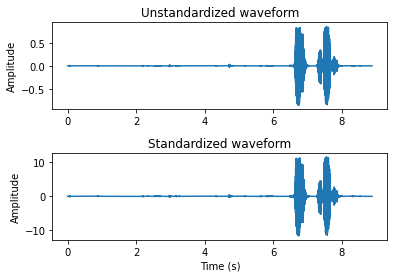

In [75]:
import dataset

# Récupération du chemin vers le fichier audio
fname = parser.DATA_DIR + metadata['train'].at[
    metadata['train'].query('is_hotword == 1')['duration'].idxmax(), 
    'audio_file_path'
]
print(f'{"Path":21}: {fname}')

# Récupération de la forme d'onde du signal et sa fréquence d'échantillonnage
waveform, sample_rate = torchaudio.load(fname)
t = numpy.linspace(
    0.0, 
    metadata['train'].groupby(['is_hotword'])['duration'].max()[HOTWORD],
    num = waveform.size()[1]
)

# Affichage du signal non traité
print(f'{"Shape of the waveform":21}: {waveform.size()}')
print(f'{"Sample rate":21}: {sample_rate}\n')
fig1 = plt.subplot(2,1,1)
fig1.plot(t, waveform.t().numpy())
fig1.set_title('Unstandardized waveform')
fig1.set_ylabel('Amplitude')

# Normalisation centrée réduite du signal
waveform = dataset.Dataset.norm(waveform)

# Affichage du signal ainsi normalisé
fig2 = plt.subplot(2,1,2)
fig2.plot(t, waveform.t().numpy())
fig2.set_title('Standardized waveform')
fig2.set_xlabel('Time (s)')
fig2.set_ylabel('Amplitude')

plt.subplots_adjust(hspace = 0.5)
plt.show()

Le fichier audio, d'une durée de 8.88s est donc échantillonné à une fréquence de **16000 Hz**.
En d'autres termes, notre signal audio de 8.88s est décomposé en **16000 x 8.88 = 142080 échantillons** (représentés sous forme de nombres flottants).

Son amplitude est maximale sur l'intervalle de temps approximatif $[6.5, 8]$. L'on s'attend donc que toute analyse ultérieure affiche des informations plus riches dans cet période ci.

### Analyse fréquentielle
Le principe d'utiliser une décomposition fréquentielle d'un fichier audio permet de grandement réduire le volume des données d'entrées. Nous pourrions bien entendu, à partir d'un signal, récupérer l'ensemble des échantillons qui le définisse, puis les répartir en trames de taille égale.
Cependant, ce procédé nécessite de charger des vecteurs de données qui peuvent vite s'avérer conséquents et, pour lesquels au final, seule une toute partie de l'information qui s'y trouve, est interessante pour le modèle.

Une analyse fréquentielle dans l'espace de Fourier par exemple est une bonne solution pour répondre à ce type de problème. Une décomposition fréquentielle sur l'échelle de Mel est également une autre alternative en ce qui concerna la réduction de l'espace des données.

#### Affichage du spectre
On décompose le signal en plages de fréquences via un **spectrogramme**. 
La classe `torchaudio.Spectrogram()`, permet ainsi de réaliser un découpage de l'audio en fenêtres de temps, pour en extraire le spectre des fréquences par transformée de Fourier.
La taille de chaque fenêtre fixée à **10ms**, nous nous attendons donc à un spectrogramme plus dense entre les fenêtres 650 et 800.

Shape of the spectrogram: torch.Size([1, 201, 889])



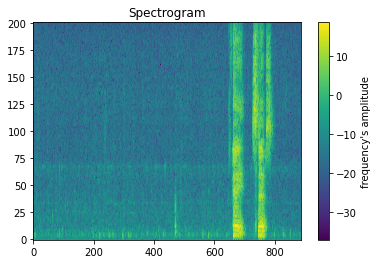

In [77]:
spectrogram = torchaudio.transforms.Spectrogram(
    win_length = 320
)(waveform)

print(f'Shape of the spectrogram: {spectrogram.size()}\n')
plt.figure()
plt.title('Spectrogram')
plt.imshow(
    spectrogram.log2()[0,:,:].numpy(), 
    cmap = 'viridis',
    interpolation = 'nearest', 
    origin = 'lower',
    aspect = 'auto'
)
plt.colorbar(label = 'frequency\'s amplitude')
plt.show()

Le graphe ci-dessus affiche la distribution fréquentielle de chaque fenêtre d'acquisition en *201 fréquences*.
Comme attendu, l'on remarque que cette distribution est manifeste pour les fenêtres décomposants le signal, dans la plage de temps comprise entre 6.5 et 8 secondes.

#### Génération des coefficients cepstraux des fréquences sur l'échelle de Mel (MFCC)

Il s'agira ici de récupérer la [MFCC](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) du signal audio, structure que nous choisirons pour représenter les données dans notre modèle.
Cette décomposition réalise une transformée de Fourier sur le signal de base sur l'[échelle de Mel](https://fr.wikipedia.org/wiki/Échelle_des_mels) et une analyse en composantes principales  du spectre ainsi obtenu.

Par défaut, la classe [`torchaudio.transforms.MFCC`](https://pytorch.org/audio/_modules/torchaudio/transforms.html) échantillonne le signal audio à **16000Hz sur 40 composantes**.
Appliquons cette configuration à notre signal audio :

Shape of the MFCC: torch.Size([889, 40])



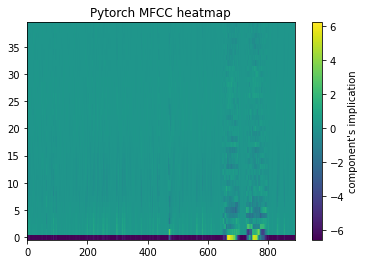

In [89]:
import torch
import torchaudio

SAMPLE_RATE = 16000

mfcc = torchaudio.transforms.MFCC(
    n_mfcc = parser.NUM_MFCC,
    sample_rate = SAMPLE_RATE, 
    melkwargs = { 'win_length': 320 }
)(waveform)
mfcc = norm(mfcc[0,:,:])
mfcc = mfcc.t()

print(f'Shape of the MFCC: {mfcc.size()}\n')
plt.figure()
plt.imshow(
    mfcc.t().numpy(), 
    interpolation = 'nearest', 
    origin = 'lower', 
    aspect = 'auto'
)
plt.colorbar(label = 'component\'s implication')
plt.title('Pytorch MFCC heatmap')
plt.show()

Cependant, nous utiliserons par la suite la fonction [`torchaudio.compliance.kaldi.mfcc`](https://pytorch.org/audio/compliance.kaldi.html#torchaudio.compliance.kaldi.mfcc), préférant la manière plus explicite de cette dernière de déclarer les paramètres d'une MFCC :

Shape of the MFCC: torch.Size([888, 40])



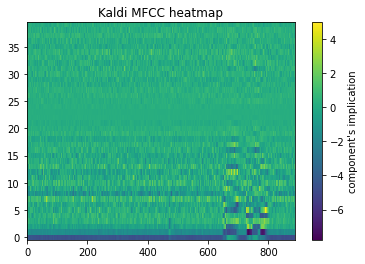

In [88]:
# Définition de la décomposition des paramètres de la MFCC
frame_length = lambda sample_rate: int(
    Dataset.N_FFT / sample_rate * 1000.0
)
MFCC_PARAMS = {
    'channel': 0,
    'dither': 0.0,
    'window_type': "hanning",
    'frame_length': frame_length(sample_rate),
    'frame_shift': frame_length(sample_rate) / 2,
    'remove_dc_offset': False,
    'round_to_power_of_two': False,
    'sample_frequency': sample_rate,
    'num_ceps': Dataset.NUM_MFCC,
    'num_mel_bins': 256,
    'snip_edges': False,
}
# Initialisation normalisée de la MFCC à partir de la forme d'onde
mfcc = norm(torchaudio.compliance.kaldi.mfcc(waveform, **MFCC_PARAMS))

print(f'Shape of the MFCC: {mfcc.size()}\n')
plt.figure()
plt.imshow(
    mfcc.t().numpy(), 
    interpolation = 'nearest', 
    origin = 'lower', 
    aspect = 'auto'
)
plt.colorbar(label = 'component\'s implication')
plt.title('Kaldi MFCC heatmap')
plt.show()

L'analyse en composantes principales affichée ici est bien plus claire et contrastée.

## Formatage des données d'entrées
Ainsi, l'on peut voir que **887 fenêtres** de **40 composantes** sont nécessaires, pour décrire la décomposition fréquentielle de l'enregistrement audio utilisé jusqu'alors.

Afin de réguler la taille des données injectées dans le modèle, il nous faudra modifier les MFCCs directements extraites des fichiers audio dans l'optique de les subdiviser et/ou ajuster à la taille d'une MFCC de taille **1000x`NUM_MFCC`**, soit d'une MFCC correspondant à la décomposition d'un signal de **10 secondes** (cela permettra de simplifier les calculs par la suite) en **`NUM_MFCC` composantes**. En plus de simplifier les vérifications et calculs, cette taille de fenêtre est suffisamment large pour garantir la contenance de l'audio étiquetté le plus long de tout le corpus.

Par conséquent, pour chaque fenêtre, chaque ligne composant leur matrice correspond à une fenêtre représentant un spectre de **10ms** de l'audio d'origine. Nous conviendrons que cela semble être bien trop étroit en terme de contexte pour supposer en déduire une quelconque information ou étiquette. Il nous faudra donc également redimensionner chaque fenêtre de sorte à ce que leur représentation matricielle soit composée de vecteurs dont la taille renseigne **1 seconde** d'information fréquentielle (par exemple).

Ce reformattage est important our éviter de saturer la couche d'entrée du système.

### Ajustement
Avant de subdiviser les audios dépassant une durée de 10 secondes, intéressons nous à l'ajustement des fichiers audio d'une durée inférieure à celle-ci. Nous aurons pour cela recourt au **zero-padding**, en comblant de vecteurs nuls la matrice representant la MFCC du signal audio. La fonction `dataset.Dataset.fit()` permet d'ajuster un morceau de MFCC à la taille souhaitée.

In [92]:
mfcc = dataset.Dataset.fit(mfcc)

print(f'Reshaped MFCC: {mfcc.size()}')
print(mfcc)

Reshaped MFCC: torch.Size([20, 100000])
tensor([[-6.5353,  0.1852,  0.1782,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


### Division
Dans le cas où la MFCC brute contient plus de **1000 trames**, il nous faut alors la découper en $n$ sous-MFCCs de taille **1000x40**. Appliquons cette logique à l'audio non-étiquetté le plus long, tout corpus confondu :

In [95]:
filename = parser.DATA_DIR + metadata['test'].at[
    metadata['test'].query('is_hotword == 0')['duration'].idxmax(), 
    'audio_file_path'
]
print(f'[ {"file"} ] {filename}')

waveform, sample_rate = torchaudio.load(filename)

# On formate la MFCC pour que celle-ci puisse être redécoupée en une série de 
# matrice de SEQ_SIZEx40
mfcc = norm(torchaudio.compliance.kaldi.mfcc(waveform, **MFCC_PARAMS))
chunks = []

for chunk in mfcc.split(Dataset.MFCC_LEN):
    chunks.append(dataset.Dataset.fit(chunk))
chunks = torch.stack(chunks)

print(f'Shape of the longest MFCC: {mfcc.shape}')
print(f'Shape of chunked MFCC    : {chunks.shape}')

[ file ] data/audio_files/1a6dd124-471a-4f20-8ed1-870082c24082.wav
Shape of the longest MFCC: torch.Size([7260, 40])
Shape of chunked MFCC    : torch.Size([8, 20, 2000])


## Chargement des données dans un `torch.utils.data.Dataset`
Il s'agira de surcharger la classe native `torch.utils.data.Dataset` afin de l'ajuster à nos besoins. À son instanciation, cette classe récupère le corpus des métadonnées qui lui est fourni, pour extraire et empiler, les MFCCs des différents fichiers audios qui y sont référencés.
Le découpage des MFCCs brutes se fait selon la même logique que décrite ci-dessus.

### Annotations
À noter que, **les annotations d'un signal seront dupliquées sur chaque échantillon de MFCC qui en est extrait**. Par exemple, si je dispose d'un audio d'une durée de 19.4s, contenant le mot clef "Hey Snips", alors les deux fenêtres de 10s échantillonnant le support d'origine, seront étiquettées à `1`.

### Enregistrement des MFCCs
Parce qu'à force d'expérience, j'ai rapidement dû envisager un système permettant de charger plus rapidement les données dans le modèle. Ainsi, on fonction du type de `Dataset`, ce dernier se chargera de générer les MFCCs de sont corpus et de les enregistrer dans `mfcc/{type}-{num_mfcc}.dat` si ce dernier n'est pas trouvé dans le dossier de données.

### Implémentation
*cf. `src/dataset.py`*

# Modèle
## Architecture
Mon choix s'est tourné vers un modèle implémentant un réseau de neurones récurrents de type **Gated Recurrent Unit (GRU)**. 
Tout comme des réseaux composés de cellules **Long Short Term Memomy**, la nature même de ces structures semble en effet bien adaptée à des problèmes d'analyse de séquences.

Par ailleurs, si l'on s'en réfère à la première partie de l'article [Coucke et al., 2018, "Efficient keyword spotting using dilated convolutions and gating"](https://arxiv.org/pdf/1811.07684.pdf) :
> *More advanced architectures have been successfully applied to KWS problems, such as Convolutional Neural Networks (CNNs) exploiting local dependencies. 
They have demonstrated efficiency in terms of inference speed and computational cost but fail at capturing large patterns with reasonably small models. Recent works have suggested RNN based keyword spotting using LSTM cells that
can leverage longer temporal context using gating mechanism and internal states. 
However, because RNNs may suffer from state saturation when facing continuous input streams, their internal state needs to be periodically reset.*

Il semblerait donc qu'une architecture de type **LSTM** (ou toute structure similaire), ou de type **CNN**, puisse répondre favorablement aux contraintes imposées par le type de problème, que nous devons traiter ici.


## Implémentation
Pour cette partie je me suis inspiré des [explications de Gabriel Loye](https://blog.floydhub.com/gru-with-pytorch/) au sujet des GRUs et de ce qui les différencie de leur homologue LSTMs.

Le modèle est composé de deux **Gated Recurrent Unit (GRU)** - chacune constituée de **128 unités cachées** et d'un taux d'oubli (**dropout**) fixé à **0.2** - dont les sorties sont filtrées par **deux réseaux de neurones linéaires**, avec entre deux, **une régression linéaire** filtrant les résultats émergeants du premier :

In [ ]:
class Net(torch.nn.Module):
    '''
    Modèle de l'application de détection de mot d'éveil.
    
    Attributs
    ----------
    (static) DEVICE: torch.device()
        Addresse de la ressource allouée pour le chargement et le traitement 
        des données d'entrées.

    lr: float
        Taux d'apprentissage du réseau de neurones.
    hidden_dim: int
        Nombre d'unités cachées composant une cellule GRU.
    gru: torch.nn.GRU
        Réseau de neurone récurrent traitant les séquences fournies par le 
        DataLoader.
    fc1: torch.nn.Linear
        Première couche linéaire transformant les données de sortie du réseau
        récurrent.
    relu: torch.nn.ReLU()
        Filtre de régression linéaire appliqué aux résultats de la première 
        couche linéaire.
    fc2: torch.nn.Linear
        Dernière couche linéaire de la propagation avant du signal d'entrée.
    optimizer: torch.optim.Adam
        Système de gestion de la rétropropagation des erreurs du modèle. Adam 
        permet notamment d'ajuster de façon dynamique la valeur du pas 
        d'apprentissage, pour accélérer le processus.
    criterion: torch.nn.BCEWithLogitsLoss
        Fonction objectif évaluant les écarts de prédictions aux étiquettes du 
        jeu de données. BCEWithLogitsLoss permet d'évaluer les résultats 
        sortant (logits) d'une couche de réseau de neurones.
    '''
    DEVICE = None



    def __init__(
        self,
        seq_len,
        lr,
        input_size, 
        hidden_dim,
        output_dim,
        num_layers,
        dropout
    ):
        super(Net, self).__init__()
        
        # Pour réduire le temps de résolution, on commence d'abord par vérifier
        # la disponibilité d'un GPU.
        if Net.DEVICE is None:
            Net.DEVICE = ( torch.device('cuda:0') if torch.cuda.is_available()
                else torch.device('cpu') )
        
        self.lr = lr
        self.hidden_dim = hidden_dim

        self.gru = torch.nn.GRU(
            input_size, 
            hidden_dim,
            num_layers,
            dropout = dropout,
            batch_first = True, 
        )
        self.fc1 = torch.nn.Linear( hidden_dim, output_dim )
        self.fc2 = torch.nn.Linear( seq_len * output_dim, output_dim )
        self.relu = torch.nn.ReLU()

        # Fonction de coût associée au modèle : permet d'estimer les 
        # prédictions du réseau à la réalité du terrain selon une certaine
        # fonction à minimiser.
        self.optimizer = torch.optim.Adam(self.parameters(), lr = self.lr)
        # self.optimizer = torch.optim.SGD(self.parameters(), lr = self.lr, momentum = 0.9)
        
        # Optimiseur du modèle en charge de la gestion de la rétropropagation 
        # des erreurs: Adam permet entre-autre d'ajuster la valeur du pas 
        # d'apprentissage.
        self.criterion = torch.nn.BCEWithLogitsLoss()
    
    
    def forward(self, x):
        out, _hidden_state = self.gru(x)
        out = self.fc1(out)
        out = self.relu(out)
        return self.fc2(out.view(out.shape[0], -1)).view(-1)
    
    
    # ...

## Utilisation
Le modèle peut être paramétré de façon quasi-intégrale de la façon suivante :

In [162]:
%run src/net.py -h

usage: net.py [-h] [-dd DATA_DIR] [-od OUT_DIR] [-e EPOCHS] [-lr LEARNING_RATE]
              [-hd HIDDEN_DIM] [-ngru NUM_GRU] [-d DROPOUT] [-nmfcc NUM_MFCC]
              [-mfccl MFCC_LEN] [-nfs NUM_FRAME_SAMPLE] [-bs BATCH_SIZE] [-p PATIENCE] [-v]
              [-cl]

optional arguments:
  -h, --help            show this help message and exit
  -dd DATA_DIR, --data_dir DATA_DIR
                        Name of the data directory (default: data/)
  -od OUT_DIR, --out_dir OUT_DIR
                        Name of the data directory (default: out/)
  -e EPOCHS, --epochs EPOCHS
                        Maximum number of iterations used for the learning process (default:
                        50)
  -lr LEARNING_RATE, --learning_rate LEARNING_RATE
                        Learning rate of each unit composing the model (default: 0.001)
  -hd HIDDEN_DIM, --hidden_dim HIDDEN_DIM
                        Number of logic units per hidden layer (default: 256)
  -ngru NUM_GRU, --num_gru NUM_GRU
     

## Méthodologie
Afin de visualiser les tendances de mon modèle en fonction du volume de données à traiter, j'ai décidé d'évaluer ses performances sur des jeux de données à taille de MFCC variable.
Ainsi, j'ai réalisé un série de 10 expériences, pour une décomposition fixée en fréquences principales sur l'échelle Mel. 
Pour chaque expérience les paramètres du modèle sont fixés comme suit :

| Option             | Descriptif                                               | Valeur                                             |
|:--------------------:|:----------------------------------------------------------:|:----------------------------------------------------:|
| `--epochs`          | Nombre d'itération maximum avant arrêt de l'entraînement | **50**                                               |
| `--learning_rate`    | Taux d'apprentissage                                     | **0.001**                                              |
| `--hidden_dim`       | Nombre d'unités par couche cachées dans une cellule GRU  | **128**                                                |
| `--num_lstm`         | Nombre de cellules GRU                                   | **2**                                                  |
| `--dropout`          | Taux d'oubli                                             | **0.2**                                                |
|                    | Durée d'une fenêtre audio                                | **1000**<br>*durée correspondante : 10s*               |
| `--num_frame_sample` | Échantillonnage d'une fenêtre                            | **50**<br>*sous-découpage de 200ms<br>des fenêtres d'audio* |
| `--batch_size`       | Nombre d'entrée composant les mini-batchs                | **128**                                                |
| `--patience`         | Patience                                                 | **5**                                                  |

## Résultats
Les graphiques affichés ci-dessous disposent tous d'une version interactive au format HTML dans le dossier `html/`.

### Évolution de la fonction de coût

In [187]:
from IPython.display import IFrame
from IPython.display import Image

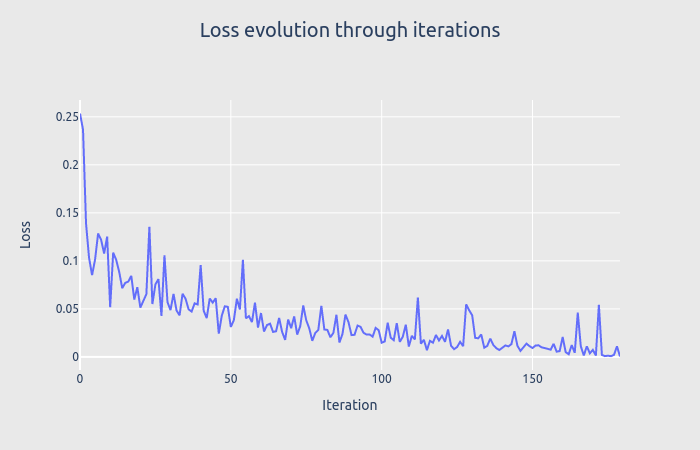

In [146]:
%run src/plotter.py -f out/loss.dat -dt loss
# IFrame(src = 'html/loss.html', width = '100%', height = 600)
Image(filename = 'img/loss.png') 

### Précision du modèle
Ci-dessous un exemple de calcul de précision de notre modèle sur le jeu de test avec analyse des fréquences Mel sur 40 composantes :
```
⚝  Accuracy:                    [ epoch:  18, avg. loss:   0.01728 ]
      True positive : 2470
      True negative : 20316
      False positive: 66
      False negative: 40
      Overall       : 99.5406%
```

### Distribution des scores de précision en fonction de la taille de la MFCC

| #Composantes principales | Moyenne | Premier quartile | Médiane | Troisième quartile |
|:------------------------:|:-------:|:----------------:|:-------:|:------------------:|
|            13            | 99.6690 |      99.6489     | 99.6706 |       99.6966      |
|            20            | 99.6346 |      99.5850     | 99.6229 |       99.6760      |
|            30            | 99.5887 |      99.5417     | 99.5887 |       99.6381      |
|            40            | 99.5466 |      99.4799     | 99.5492 |       99.6164      |

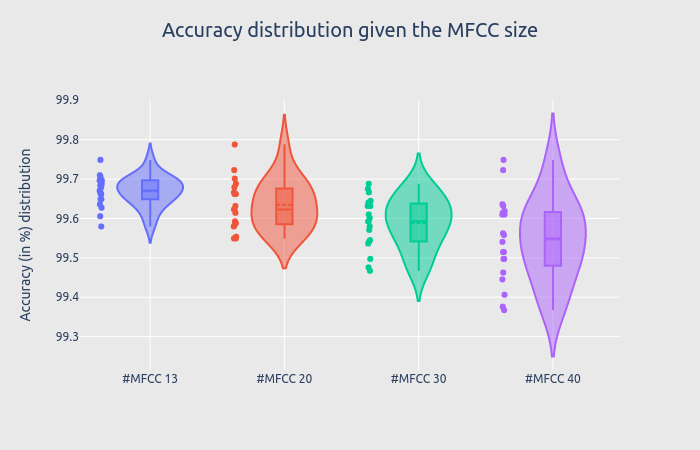

In [189]:
%run src/plotter.py -f out/eval.dat -dt eval
Image(filename = 'img/eval.png')
# IFrame(src = 'html/eval.html', width = '100%', height = 600)

# Conclusion
## Analyse
D'après le graphique précédent, affichant la distribution des scores de précision du modèle, sur différents volumes de données, on remarque que plus la dimension augmente, plus celle-ci est facteur de fluctuations dans les performances du système. Ceci peut tout simplement être dû au fait que les dimensions notre configuration ne semblent pas suffire pour assurer au modèle de fournir des résultats stables. Ce qui semble être logique puisque, plus la taille des données d'entrée est importante, plus le système se doit d'être complexe (*i.e.* nécessite plus d'unités cachées et/ou de couches / unités GRU) pour en extraire les informations pertinentes.

En plus de fournir des résultats de plus en plus hétérogènes (l'on observe en effet des valeurs de plus en plus aberrantes avec le nombre croissant de composantes principales constituant les MFCCs, mais également des intervalles interquartiles de plus en plus conséquents) en fonction du volume des données d'entrées, la moyenne semble être également négativement impactée par ce facteur. Ainsi, l'on passe de **99.6690%** de score de précision moyen sur le jeu de test pour des MFCCs de **13 composantes**, à un score moyen de **99.5466%** pour des MFCCs de **40 composantes**.

Malgré tout, on prendra soin de noter que le taux de faux-positifs reste relativement faible (aux alentours de **2.5%**).
Le système semble donc être relativement fiable en ce qui concerne le déclenchement et la détection de mots d'éveils.

## Améliorations
Le modèle gagnerait à être amélioré sur la phase d'initialisation des ses poids. 
Comme mentionné dans l'article [Ioffe, Sergey, and Christian Szegedy. "Batch normalization: Accelerating deep network training by reducing internal covariate shift." arXiv preprint arXiv:1502.03167 (2015)](https://arxiv.org/pdf/1502.03167.pdf), les système récurrents sont très sensibles au paramétrage initial des ses poids, ce qui peut expliquer en partie pourquoi les résultats obtenus précédemment varient fortement d'une expérience à l'autre.

Par ailleurs, afin de compenser la sureprésentation des données non étiquettées (*i.e.* ne comportant pas le mot d'éveil), je pourrais également modifier la fonction de coût dans l'optique d'attribuer un poids plus important aux prédictions portant sur des échantillons annotés. Aussi et non des moindres, accroître le volume des données annotées du jeu d'entraînement par augmentation, pourrait contribuer à amoindrir l'impact du déséquilibre sur l'ajustement du modèle.

## Rétrospective
Bien qu'il semble que des l'on obtienne des résultats satisfaisant avec des MLPs classiques, je suis satisfait d'avoir réussi à implémenter une architecture intégrant un réseau de neurones récurrent.
Ce projet fut l'occasion pour moi de diversifier mes compétences en terme de conception de modèle neuronal.

Des points d'ombre majeurs restent néanmoins à déplorer :
- **Mon système reste parfois bloqué à 89.0404% lors de la phase d'apprentissage, et semble s'obstiner à ne fournir que des réponses sans étiquettes**, quelque soit l'audio qui lui soit donné d'analyser. Malgré mes nombreuses modifications, je n'ai pas réussi à corriger ce problème, somme toute très embarrassant. J'ai cependant réussi à trouver une solution de contournement, consistant à arrêter le processus d'apprentissage dès lors que cette situation se présente (généralement, cela se produit dès la première itération) et de le relancer de nouveau. Ce bémol pourrait s'expliquer selon deux facteurs : 
    - le premier, relevant de *la disproportion des données non étiquettées* confortant le système dans sa configuration.
    - le second, et sans doute plus probable, lié à *une mauvaise implémentation de mon modèle*. J'ai effectivement pû remarquer que parfois, un mauvais paramètrage peut parfois avoir des conséquences explosives sur les réponses du système.
- J'aurais aimé disposé de **plus de travaux pratiques autour de la thématique des réseaux de neurones récurrents**. Cela est dommageable car finalement, en-dehors des réseaux de neurones multicouches, je me rends compte que mes facultés à concevoir une architecture neuronale sont assez restreintes et, je ne pense pas être le seul dans cette situation malheureusement. Personnellement je trouve que, disposer de l'expérience d'un professeur sur des problèmes de ce genre et pouvoir s'entretenir directement avec lui, tableau à l'appui, sont des vecteurs de compréhension essentiels pour assimiler ces concepts. C'est d'ailleurs là que se démarque les universités par rapport à des plateformes d'enseignement en ligne telles que Coursera et consorts. Gageons d'espérer que nous puissions explorer et appronfondir cette thématique l'année prochaine.